In [1]:
#Block for imports and other setting that will be required for the code to run
import os
import sys
import re
import time
import datetime
import random
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df1 = pd.read_csv('new_iso1_group_names.csv',)

In [3]:
df1.head()

,Blend Number,Original Blend Name,Blend Type,Replacement Level,Group_names,PC,GPP,SC,CC,FA,VA,GBA,FBC,QUARTZ,PLC,Cumulative Heat (J/g)
0,0,100% PC,Other,0,X,100,0,0,0,0,0,0,0,0,0,323.16
1,1,80% PC + 20% GPP,Binary,20,Group_1_PC_GP,80,20,0,0,0,0,0,0,0,0,297.77
2,2,70% PC + 30% GPP,Binary,30,Group_1_PC_GP,70,30,0,0,0,0,0,0,0,0,311.40
3,3,60% PC + 40% GPP,Binary,40,Group_1_PC_GP,60,40,0,0,0,0,0,0,0,0,265.35
4,4,50% PC + 50% GPP,Binary,50,Group_1_PC_GP,50,50,0,0,0,0,0,0,0,0,225.05


In [33]:
# Create a mapping dictionary to rename groups for better clarity
rename_mapping = {
    'Group_1_PC_GP': 'PC with GP',
    'Group_3_PC_Q': 'PC with Quartz',
    'Group_2_PLC_GPP': 'PLC with GP',  # Adjust based on actual group naming
    'Group_4_PLC_Q': 'PLC with Quartz',
    'Group_5_3_PC_30': 'Ternary with 30% PC',
    'Group_6_3_PC_40': 'Ternary with 40% PC',
    'Group_7_3_PC_50': 'Ternary with 50% PC',
    'Group_8_3_PLC_30': 'Ternary with 30% PLC',
    'Group_9_3_PLC_40': 'Ternary with 40% PLC',
    'Group_10_3_PLC_50': 'Ternary with 50% PLC',
    'Group_11_3_PC_10': 'Ternary with 10% PC',
    'Group_12_3_PC_20': 'Ternary with 20% PC',
}

# Rename the values in the Group_names column using the mapping
df1['Group_names'] = df1['Group_names'].replace(rename_mapping)

# Verify the changes
print("Unique Group Names After Renaming:")
print(df1['Group_names'].unique())

Unique Group Names After Renaming:
['X' 'PC with GP' 'Ternary with 10% PC' 'Ternary with 20% PC'
 'Ternary with 30% PC' 'Ternary with 40% PC' 'Ternary with 50% PC'
 'PC with Quartz' 'PLC with GP' 'Ternary with 40% PLC'
 'Ternary with 50% PLC' 'Ternary with 30% PLC' 'PLC with Quartz']


In [42]:
# Count the number of entries in each group
group_counts = df1.groupby('Group_names').size().reset_index(name='Count')
print("\nGroup Counts:")
print(group_counts)


Group Counts:
             Group_names  Count
0             PC with GP      6
1         PC with Quartz      6
2            PLC with GP      5
3        PLC with Quartz      5
4    Ternary with 10% PC      1
5    Ternary with 20% PC      1
6    Ternary with 30% PC     26
7   Ternary with 30% PLC     23
8    Ternary with 40% PC      4
9   Ternary with 40% PLC      4
10   Ternary with 50% PC      4
11  Ternary with 50% PLC      4
12                     X      3


In [43]:
group_summary = df1.groupby('Group_names')['Cumulative Heat (J/g)'].agg(['mean', 'median', 'std']).reset_index()
print("\nCumulative Heat Summary by Group:")
print(group_summary)


Cumulative Heat Summary by Group:
             Group_names        mean   median         std
0             PC with GP  246.138333  245.200   56.426974
1         PC with Quartz  229.538333  240.330   57.794374
2            PLC with GP  246.232000  251.610   33.929140
3        PLC with Quartz  256.506000  264.260   38.358624
4    Ternary with 10% PC  115.700000  115.700         NaN
5    Ternary with 20% PC  149.980000  149.980         NaN
6    Ternary with 30% PC  176.442692  174.150   19.871955
7   Ternary with 30% PLC  168.736957  159.340   20.570325
8    Ternary with 40% PC  198.137500  197.655    9.658493
9   Ternary with 40% PLC  196.250000  191.225   11.816838
10   Ternary with 50% PC  226.557500  229.940    7.989712
11  Ternary with 50% PLC  222.070000  221.350    3.731559
12                     X  212.516667  303.150  174.597601


In [44]:
# Calculate mean cumulative heat for each group
group_mean = df1.groupby('Group_names')['Cumulative Heat (J/g)'].mean().reset_index()
print("Mean Cumulative Heat by Group:")
print(group_mean)

Mean Cumulative Heat by Group:
             Group_names  Cumulative Heat (J/g)
0             PC with GP             246.138333
1         PC with Quartz             229.538333
2            PLC with GP             246.232000
3        PLC with Quartz             256.506000
4    Ternary with 10% PC             115.700000
5    Ternary with 20% PC             149.980000
6    Ternary with 30% PC             176.442692
7   Ternary with 30% PLC             168.736957
8    Ternary with 40% PC             198.137500
9   Ternary with 40% PLC             196.250000
10   Ternary with 50% PC             226.557500
11  Ternary with 50% PLC             222.070000
12                     X             212.516667


In [45]:
# For PC-based blends, baseline is 'PC with Quartz'
# For PLC-based blends, baseline is 'PLC with Quartz'
baseline_pc = round(group_mean[group_mean['Group_names'] == 'PC with Quartz']['Cumulative Heat (J/g)'].values[0],2)
baseline_plc = round(group_mean[group_mean['Group_names'] == 'PLC with Quartz']['Cumulative Heat (J/g)'].values[0],2)

print("\nBaseline PC (PC with Quartz):", baseline_pc)
print("Baseline PLC (PLC with Quartz):", baseline_plc)


Baseline PC (PC with Quartz): 229.54
Baseline PLC (PLC with Quartz): 256.51


In [46]:
#Define relevant groups (excluding the Quartz-based baselines)

pc_groups = ['PC with GP', 'Ternary with 30% PC', 'Ternary with 40% PC', 'Ternary with 50% PC','Ternary with 10% PC' ,'Ternary with 20% PC']
plc_groups = ['PLC with GP', 'Ternary with 30% PLC', 'Ternary with 40% PLC', 'Ternary with 50% PLC']

In [47]:
#  Create a new column 'Delta_Heat' in the group_mean DataFrame by comparing against the baseline
def calc_diff(row):
    if row['Group_names'] in pc_groups:
        return row['Cumulative Heat (J/g)'] - baseline_pc
    elif row['Group_names'] in plc_groups:
        return row['Cumulative Heat (J/g)'] - baseline_plc
    else:
        # For baseline groups (and any others), return None or 0
        return None

group_mean['Delta_Heat'] = group_mean.apply(calc_diff, axis=1)

print("\nGroup Mean with ΔHeat (Difference relative to Quartz-based binary blend):")
print(group_mean)


Group Mean with ΔHeat (Difference relative to Quartz-based binary blend):
             Group_names  Cumulative Heat (J/g)  Delta_Heat
0             PC with GP             246.138333   16.598333
1         PC with Quartz             229.538333         NaN
2            PLC with GP             246.232000  -10.278000
3        PLC with Quartz             256.506000         NaN
4    Ternary with 10% PC             115.700000 -113.840000
5    Ternary with 20% PC             149.980000  -79.560000
6    Ternary with 30% PC             176.442692  -53.097308
7   Ternary with 30% PLC             168.736957  -87.773043
8    Ternary with 40% PC             198.137500  -31.402500
9   Ternary with 40% PLC             196.250000  -60.260000
10   Ternary with 50% PC             226.557500   -2.982500
11  Ternary with 50% PLC             222.070000  -34.440000
12                     X             212.516667         NaN


C:\Users\raksh\AppData\Local\Temp\ipykernel_55552\4139148303.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Group_names', y='Cumulative Heat (J/g)', data=group_mean, palette='viridis')


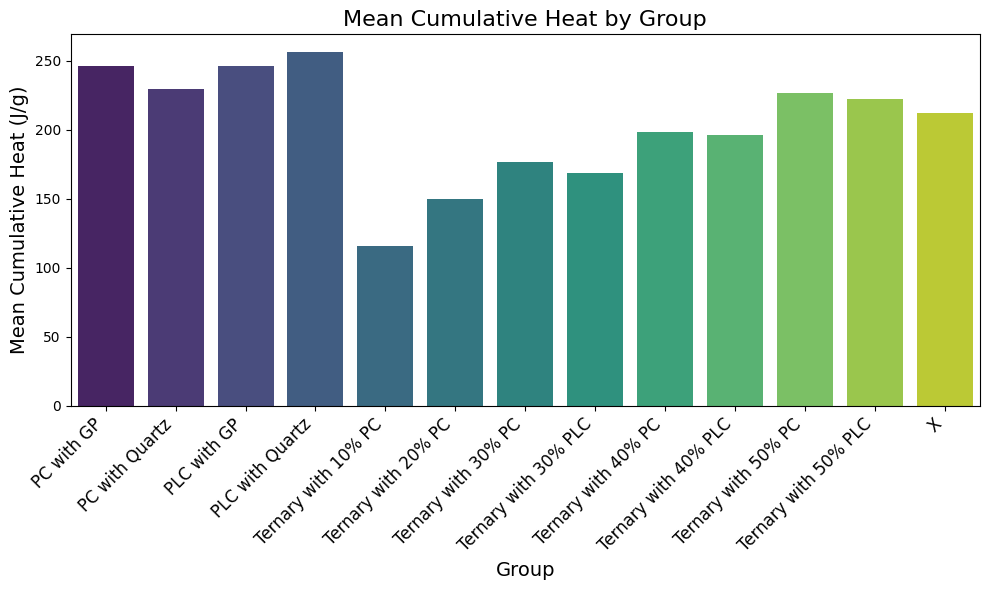

In [ ]:
# --- Visualization 1: Mean Cumulative Heat by Group ---

plt.figure(figsize=(10,6))
sns.barplot(x='Group_names', y='Cumulative Heat (J/g)', data=group_mean, palette='viridis')
plt.title('Mean Cumulative Heat by Group', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Mean Cumulative Heat (J/g)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\raksh\AppData\Local\Temp\ipykernel_55552\3381662983.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Group_names', y='Delta_Heat', data=delta_df, palette='coolwarm')


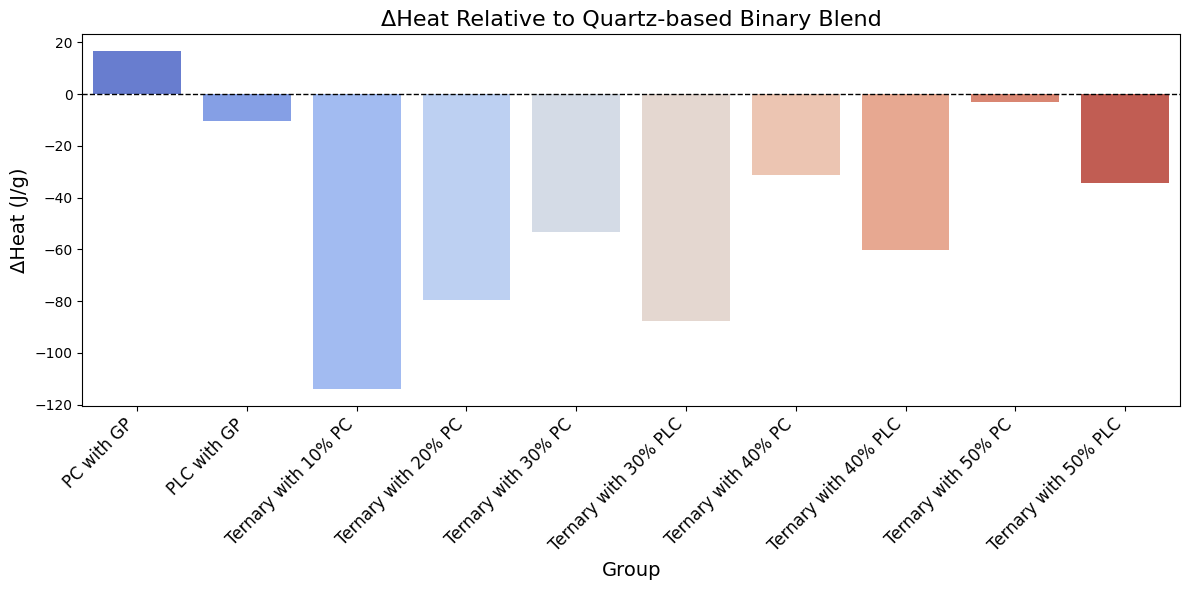

In [53]:
# --- Visualization 2: ΔHeat (Difference relative to Quartz-based Binary Blend) ---
# Filter out rows that do not have a Delta_Heat value (i.e., the baseline groups and any unmapped groups)
delta_df = group_mean.dropna(subset=['Delta_Heat'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Group_names', y='Delta_Heat', data=delta_df, palette='coolwarm')
plt.title('ΔHeat Relative to Quartz-based Binary Blend', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('ΔHeat (J/g)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Reference line at 0
plt.tight_layout()
plt.show()

In [55]:
import plotly.express as px

# Interactive bar chart for mean cumulative heat
fig = px.bar(
    group_mean,
    x="Group_names",
    y="Cumulative Heat (J/g)",
    title="Interactive Mean Cumulative Heat by Group",
    labels={"Group_names": "Group", "Cumulative Heat (J/g)": "Mean Cumulative Heat (J/g)"},
    text="Cumulative Heat (J/g)"
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [57]:
# Calculate percentage difference relative to baseline
def calc_percent_diff(row):
    if row['Group_names'] in pc_groups:
        return (row['Delta_Heat'] / baseline_pc) * 100 if baseline_pc != 0 else None
    elif row['Group_names'] in plc_groups:
        return (row['Delta_Heat'] / baseline_plc) * 100 if baseline_plc != 0 else None
    else:
        return None

group_mean['Percent_Difference'] = group_mean.apply(calc_percent_diff, axis=1)

# Filter out baseline groups (which have no ΔHeat) for visualization
delta_df = group_mean.dropna(subset=['Delta_Heat']).copy()

# Create an annotation column that combines ΔHeat and percentage difference
delta_df['Annotation'] = delta_df.apply(
    lambda row: f"{row['Delta_Heat']:.2f} J/g<br>{row['Percent_Difference']:.1f}%", axis=1
)

# --- Create the Interactive Bar Chart ---
fig = px.bar(
    delta_df,
    x="Group_names",
    y="Delta_Heat",
    title="Interactive ΔHeat Relative to Quartz-Based Binary Blends",
    labels={"Group_names": "Group", "Delta_Heat": "ΔHeat (J/g)"},
    color="Delta_Heat",
    color_continuous_scale="RdBu"
)

# Add annotations to the bars
fig.update_traces(text=delta_df['Annotation'], textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()